In [ ]:
!pip install mediapipe opencv-python

     |████████████████████████████████| 30.4 MB 79 kB/s 


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

In [ ]:
from google.colab import drive # 국방부 해커톤/input에 있는 영상 사본 만들고 사본을 옮겨서 이름 바꾸기 / 원본 안옮기게 주의!
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Finding XYZ**

In [ ]:
def find_xyz(ind_list, landmark):
  a = landmark[ind_list[0]]
  b = landmark[ind_list[1]]
  c = landmark[ind_list[2]]

  first = [a.x,a.y,a.z]
  mid = [b.x,b.y,b.z]
  end = [c.x,c.y,c.z]
  return first, mid, end

# **Calculating Angle**

In [ ]:
def calculate_angle3D_left(a,b,c):
  """
  Video(photo) for a person's left side
  calculate_angle3D is divided by left and right side because this function uses external product
  input : landmark with shape [x,y,z,visibility]
  output : angle between ba and bc with range 0~360
  """
  # external product's z value
  external_z = (b[0]-a[0])*(b[1]-c[1]) - (b[1]-a[1])*(b[0]-c[0])

  a = np.array(a) #first
  b = np.array(b) #mid
  c = np.array(c) #end

  ba = b-a
  bc = b-c
  dot_result = np.dot(ba, bc)


  ba_size = np.linalg.norm(ba)
  bc_size = np.linalg.norm(bc)
  radi = np.arccos(dot_result / (ba_size*bc_size))
  angle = np.abs(radi*180.0/np.pi)

  # left side
  if external_z < 0:
    angle = 360 - angle

  return angle


In [ ]:
def calculate_angle3D_right(a,b,c):
  """
  Video(photo) for a person's right side
  calculate_angle3D is divided by left and right side because this function uses external product
  input : landmark with shape [x,y,z,visibility]
  output : angle between ba and bc with range 0~360
  """
  a = a[:3]
  b = b[:3]
  c = c[:3]
  # external product's z value
  external_z = (b[0]-a[0])*(b[1]-c[1]) - (b[1]-a[1])*(b[0]-c[0])

  a = np.array(a) #first
  b = np.array(b) #mid
  c = np.array(c) #end

  ba = b-a
  bc = b-c
  dot_result = np.dot(ba, bc)


  ba_size = np.linalg.norm(ba)
  bc_size = np.linalg.norm(bc)
  radi = np.arccos(dot_result / (ba_size*bc_size))
  angle = np.abs(radi*180.0/np.pi)
  
  # right side
  if external_z > 0:
    angle = 360 - angle

  return angle


# **Checking Angle(xyz)  & Feedback to Pose**

In [ ]:
print(cnt)

2


In [ ]:
# 팕꿈치가 완전히 수축 이완을 했는지, 골반이 과도하게 올라가거나 내려가지 않았는지 판단함.

counter = 0
stage = None
video_path = "/content/wrong/1.mp4"
cap = cv2.VideoCapture(video_path)
elbow_state = 'up'
# 팔굽 갯수
cntw1 = 0
# 골반이 과도하게 내려간 횟수
cntlh = 0
# 골반이 과도하게 올라간 횟수
cnthh = 0

# 좌측관절값
joint_indx = {'check_left_elbow':[15,13,11],'check_left_hip':[11,23,25],'check_left_knee':[23,25,27]} 
save_angle3D_w1 = {'check_left_elbow':[],'check_left_hip':[],'check_left_knee':[]}
"""
save_angel_3D_w1는 영상 시작부터 끝까지 해당 관절 부분의 각도를 측정함.
temp_w1은 팔굽혀펴기 운동을 한번 할떄마다(내려갔다 올라올 떄마다) 해당 관절 부분의 각도를 최신화함. 이전에 했던 팔굽혀펴기의 각도값들은 다 초기화함.
      -> 앱 상에서 무리가 가지않게 list를 초기화시켜줌.
"""
temp_w1 = {'check_left_elbow':[],'check_left_hip':[],'check_left_knee':[]}
feedback = {'Is_elbow_up' : [], 'Is_elbow_down' : [], 'hip_condition' : []}
"""
feedback['Is_elbow_up'] -> 팔꿈치를 완전히 펴면 1의 값을 추가, 완전히 펴지 않으면 0의 값을 추가
feedback['Is_elbow_down'] -> 팔꿈치를 완전히 굽히면 1의 값을 추가, 완전히 굽히지 않으면 0의 값을 추가
feedback['hip_condition'] -> 골반이 정상이면 0, 너무 내려가면 1, 너무 올라가면 2값을 pushup 하나씩 할때마다 값을 추가
"""

if cap.isOpened():
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    res=(int(width), int(height))
    fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
    out = cv2.VideoWriter('wtemp1.mp4', fourcc, 20.0, res)

    frame = None
    while True:
      try:
        ret, frame = cap.read()
      except cv2.error:
        continue
      if not ret:
        break

      image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      results = pose.process(image)

      if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        for id, im in enumerate(results.pose_landmarks.landmark):
          h, w, c = frame.shape
          cx, cy = int(im.x*w), int(im.y*h)
          cv2.circle(frame, (cx,cy), 5, (255, 0, 0), cv2.FILLED)
        landmark = results.pose_landmarks.landmark
        for key,val in joint_indx.items():
          first,mid,end = find_xyz(val, landmark)
          angle = calculate_angle3D_left(first,mid,end) #각도 계산
          mid = mid[0:2]
          cv2.putText(frame, str(angle),tuple(np.multiply(mid, [2400,1080]).astype(int)),cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0),5,cv2.LINE_AA)
          save_angle3D_w1[key].append(angle)
          temp_w1[key].append(angle)
 
        #아래는 카운트 세는 박스 생성 및 텍스트생성
        elbow_angle = save_angle3D_w1['check_left_elbow'][-1]
        if elbow_angle > 135 and elbow_state == 'down':
            elbow_state = 'up'
            cntw1 += 1
            # 팔꿈치를 핀 정도가 160도보다 큰 경우
            if max(temp_w1['check_left_elbow']) > 160:
              feedback['Is_elbow_up'].append(1)
            # 팔꿈치를 덜 핀 경우
            else:
              feedback['Is_elbow_up'].append(0)
            # 팔꿈치를 굽힌 정도가 90도보다 작은 경우
            if min(temp_w1['check_left_elbow']) < 90:
              feedback['Is_elbow_down'].append(1)
            # 팔꿈치를 덜 굽힌 경우
            else:
              feedback['Is_elbow_down'].append(0)
            # 팔꿈치 각도 데이터 초기화 (어플에서의 변수 저장 값이 많아지는 것을 방지하기 위해 팔굽 하나 할때마다 각도 축적해놓은거를 초기화함.)
            temp_w1['check_left_elbow'] = []
            # 팔꿈치 굽혔다 필 동안 골반이 160도보다 내려갔는지(골반이 너무 아래로 내려갔는지)
            if min(temp_w1['check_left_hip']) < 160:
              cntlh += 1
              feedback['hip_condition'].append(1)
            # 팔꿈치 굽혔다 필 동안 골반이 220도보다 올라갔는지(골반이 너무 위로 올라갔는지)
            elif max(temp_w1['check_left_hip']) > 220:
              cnthh += 1
              feedback['hip_condition'].append(2)
            # 팔굽하는 동안 골반이 정상 자세(160~220도 사이값)인 경우
            else:
              feedback['hip_condition'].append(0)
            temp_w1['check_left_hip'] = []
            temp_w1['check_left_knee'] = []
        if elbow_angle < 130 and elbow_state == 'up':
            elbow_state = 'down'

        # cv2.rectangle(frame, (150,150), (500,300),(245,117,16),-1)
        # cv2.putText(frame, 'COUNT', (200,200), cv2.FONT_HERSHEY_PLAIN,3,(0,0,0),1, cv2.LINE_AA)
        cv2.putText(frame, str(cntw1), (200,300), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255),2, cv2.LINE_AA)
        cv2.putText(frame, 'L hip'+str(cntlh), (200,600), cv2.FONT_HERSHEY_PLAIN, 4, (255,0,0),2, cv2.LINE_AA)
        cv2.putText(frame, 'H hip'+str(cnthh), (200,800), cv2.FONT_HERSHEY_PLAIN, 4, (255,0,0),2, cv2.LINE_AA)

      out.write(frame)
    out.release()



In [ ]:

print('total number of pushups: {}'.format(cntw1))
print('Is elbow_up', feedback['Is_elbow_up'])
print('Is elbow_down', feedback['Is_elbow_down'])
print('hip_condition', feedback['hip_condition'])

total number of pushups: 7
Is elbow_up [1, 1, 1, 1, 1, 1, 1]
Is elbow_down [1, 1, 1, 1, 0, 1, 1]
hip_condition [1, 1, 1, 1, 1, 1, 1]


In [ ]:
cntw1

7

In [ ]:
cntlh

7

In [ ]:
cnthh

0

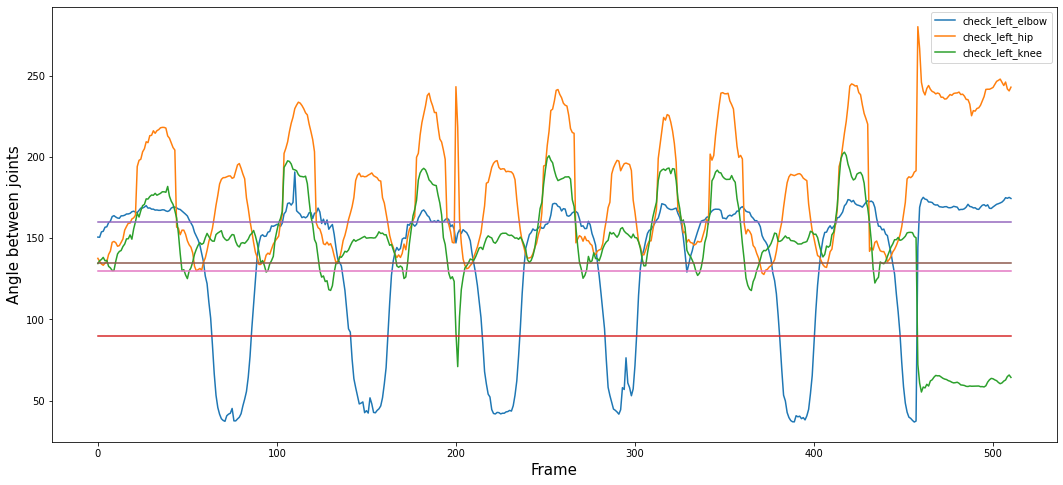

In [ ]:
import matplotlib.pyplot as plt

L = len(save_angle3D_w1['check_left_elbow'])
a = [90 for i in range(L)]
b = [160 for i in range(L)]
c = [135 for i in range(L)]
d = [130 for i in range(L)]

plt.figure(figsize=(18,8))
plt.xlabel('Frame', fontsize=15)
plt.ylabel('Angle between joints', fontsize=15)

for key in save_angle3D_w1.keys():
  # shoulder isn't that important in pushups
  if key != 'check_left_shoulder':
    plt.plot(save_angle3D_w1[key], label=key)

plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot(d)

leg = plt.legend(loc='best')

plt.savefig('w1.jpg', dpi=300)

#160~220 hip

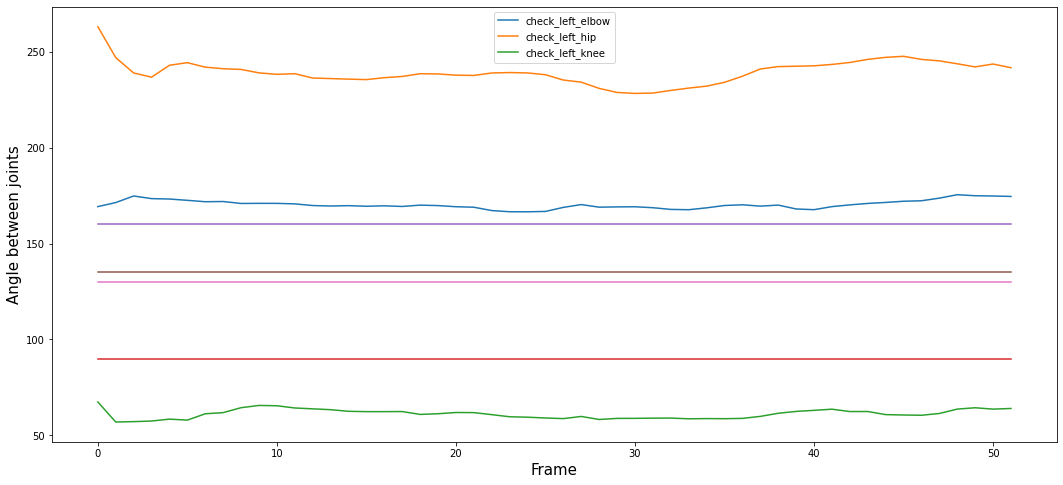

In [ ]:
# 팔굽 하나 할때마다 temp 값이 초기화 되는 것을 확인하기 위해 temp를 plotting함.
# 맨 마지막 부분(내려갔다 올라온 부분) 전까지는 다 잘리고 영상 끝부분만 남게된것을 볼 수 있음.

import matplotlib.pyplot as plt

L = len(temp_w1['check_left_elbow'])
a = [90 for i in range(L)]
b = [160 for i in range(L)]
c = [135 for i in range(L)]
d = [130 for i in range(L)]

plt.figure(figsize=(18,8))
plt.xlabel('Frame', fontsize=15)
plt.ylabel('Angle between joints', fontsize=15)

for key in temp_w1.keys():
  # shoulder isn't that important in pushups
  if key != 'check_left_shoulder':
    plt.plot(temp_w1[key], label=key)

plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot(d)

leg = plt.legend(loc='best')

plt.savefig('wtemp1.jpg', dpi=300)

In [ ]:
from google.colab import files
files.download('wtemp1.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>